In [1]:
# Note need r5.4xl to run this on
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
%pip install pymysql
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

import sagemaker
from sagemaker.sklearn.estimator import SKLearn

%load_ext autoreload
%autoreload 2

The scikit-learn version is 1.1.3.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# configuration
use_cache = True
seed = random.randint(0, 100)

print(f'Seed: {seed}')

Seed: 41


In [3]:
query = f"select * from fn_dsml_sfere_features_v2_fl();"
fl_features = cb_utils.sql_query_to_df(query, use_cache=use_cache, source='member_doc')

Pulling query from db


In [4]:
fl_features.head()

,sfere_id,patient_id,sfere_type_ft,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,bathing_support_days_natural_ft,dressing_support_days_natural_ft,eating_support_days_natural_ft,grooming_support_days_natural_ft,toileting_support_days_natural_ft,mobility_support_days_natural_ft,transfer_bed_to_chair_support_days_natural_ft,turn_change_position_support_days_natural_ft,bathing_transfers_support_days_natural_ft,dressing_lower_support_days_natural_ft,hair_support_days_natural_ft,mobility_outside_support_days_natural_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,calling_friends_and_family_support_days_natural_ft,finances_support_days_natural_ft,laundry_support_days_natural_ft,housework_support_days_natural_ft,meal_prep_support_days_natural_ft,medication_management_support_days_natural_ft,shopping_support_days_natural_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alz_or_dem_ft,has_acquired_cognitive_deficit_ft,has_developmental_delay_ft,has_idd_ft,has_no_cog_deficit_ft,has_traumatic_brain_injury_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,mean_supports_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,8590,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,14.0,14.0
1,55517,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,14.0,14.0
2,6376,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,20.0,20.0
3,6380,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,20.0
4,76130,2115,2,4,2,69.0,3,0,3,3,3,3.0,3,None,1,2.0,2.0,2.0,2.0,7.0,7.0,7.0,NaN,NaN,None,None,None,None,None,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,None,3.0,None,None,None,None,None,NaN,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,5.75,20.0,20.0


In [110]:
# exclude missing target
df = fl_features.loc[~fl_features.reporting_rec_hrs_tg.isna()]
df = df.loc[~fl_features.reporting_current_hrs_ft.isna()]
df = df.loc[fl_features.reporting_rec_hrs_tg > 0]

In [111]:
identifiers = ['sfere_id', 'patient_id']
cat_demo = [ 'sfere_type_ft', 'payer_id_ft', 'group_id_ft']
cont_demo = ['age_ft', 'reporting_current_hrs_ft']
adl_iadl = [
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
     
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
]

nat_support = [
 'bathing_support_days_natural_ft',
 'dressing_support_days_natural_ft',
 'eating_support_days_natural_ft',
 'grooming_support_days_natural_ft',
 'toileting_support_days_natural_ft',
 'mobility_support_days_natural_ft',
 'transfer_bed_to_chair_support_days_natural_ft',
 'turn_change_position_support_days_natural_ft',
 'bathing_transfers_support_days_natural_ft',
 'dressing_lower_support_days_natural_ft',
 'hair_support_days_natural_ft',
 'mobility_outside_support_days_natural_ft',
   
 'calling_friends_and_family_support_days_natural_ft',
 'finances_support_days_natural_ft',
 'laundry_support_days_natural_ft',
 'housework_support_days_natural_ft',
 'meal_prep_support_days_natural_ft',
 'medication_management_support_days_natural_ft',
 'shopping_support_days_natural_ft',
 'mean_supports_ft',
]

cog = [
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alz_or_dem_ft',
 'has_acquired_cognitive_deficit_ft',
 'has_developmental_delay_ft',
 'has_idd_ft',
 'has_no_cog_deficit_ft',
 'has_traumatic_brain_injury_ft',
]

dme = [
 'on_ventilator_ft',
 'using_oxygen_ft',
 'has_paralysis_ft',
 'has_amputations_ft',
 'receive_wound_care_ft',
 'has_ostomy_ft',
 'receiving_enteral_feedings_ft',
 'using_specialized_bed_ft',
 'using_mobility_device_ft',
 'has_dme_ft',
] 

target = 'reporting_rec_hrs_tg'

In [142]:
df = df.assign(
    total_impairment=df[adl_iadl].sum(axis=1)
    , total_cog=df[cog].sum(axis=1)
    , total_dme=df[cog].sum(axis=1)
)
df.total_impairment.value_counts()

11.0    295
13.0    291
12.0    280
14.0    275
10.0    275
15.0    266
16.0    263
9.0     261
17.0    260
18.0    235
20.0    227
7.0     224
8.0     220
23.0    213
22.0    204
6.0     202
19.0    198
21.0    194
24.0    185
27.0    183
25.0    173
28.0    173
26.0    172
29.0    149
30.0    137
5.0     134
31.0    129
50.0    126
32.0    118
33.0    111
4.0     110
3.0      95
34.0     82
36.0     81
38.0     66
35.0     65
40.0     53
37.0     49
41.0     46
48.0     44
43.0     43
47.0     42
45.0     41
46.0     39
39.0     38
42.0     33
2.0      32
44.0     32
49.0     22
1.0      13
0.0       1
Name: total_impairment, dtype: int64

In [143]:
test_pct = 0.1

patient_ids = df.patient_id.unique().tolist()
test_df_patient_ids = random.sample(patient_ids, int(df.shape[0]*test_pct))

test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]

print(f'{test_df.shape[0]} test samples, for {len(test_df_patient_ids)} unique patients')
print(f'{training_df.shape[0]} training samples, for {training_df.patient_id.unique().shape[0]} unique patients')

983 test samples, for 720 unique patients
6217 training samples, for 4758 unique patients


### start with current hours

In [144]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [145]:
y_train = training_df[target]
y_test = test_df[target]

avg rec - cur: -2.0446614122567155
Base MAE: 2.13


/Users/bp/miniforge3/envs/data-analytics/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


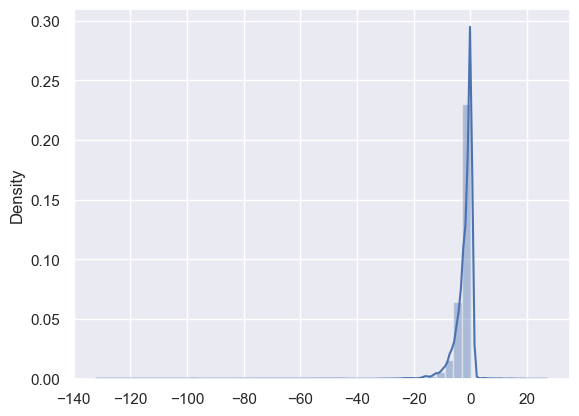

In [146]:
print('avg rec - cur:', np.mean(y_train - training_df.reporting_current_hrs_ft))
# np.std(y_test - test_df.reporting_current_hrs_ft)
sns.distplot(y_train - training_df.reporting_current_hrs_ft)

print(f'Base MAE: {np.mean(np.abs(y_train - training_df.reporting_current_hrs_ft)):.02f}')

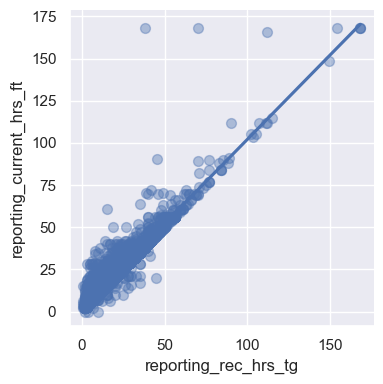

In [173]:
sns.lmplot(
    data=df, x=target, y="reporting_current_hrs_ft", palette="muted", ci=None, height=4, scatter_kws={"s": 50, "alpha": .4}
)

In [147]:
def try_features(features):
    print('features', features)
    x_train = training_df[features]
    x_test = test_df[features]
    pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), StandardScaler(), linear_model.Ridge(alpha=.5))

    pipe.fit(x_train, y_train)

    preds = pipe.predict(x_test)

    # preds vs rec
    ax = sns.relplot(x=y_test, y=preds, height=4, hue=np.abs(y_test - preds))
    ax.set(ylim=(0, 120))
    ax.set(xlim=(0, 120))
    ax.set(title=f'Sfere Model; R2:{pipe.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}');
    plt.show()


    print('coef: ', pipe['ridge'].coef_)

features ['reporting_current_hrs_ft']


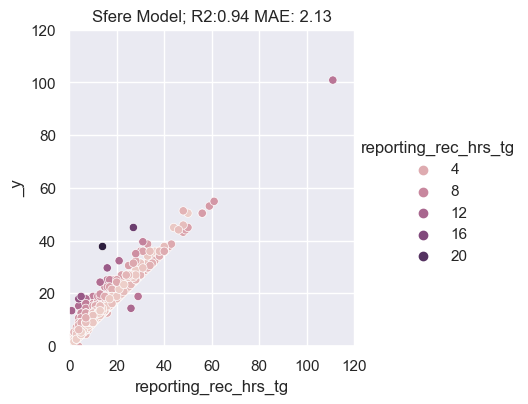

coef:  [11.6898322]


In [138]:
try_features(['reporting_current_hrs_ft'])

features ['reporting_current_hrs_ft', 'age_ft']


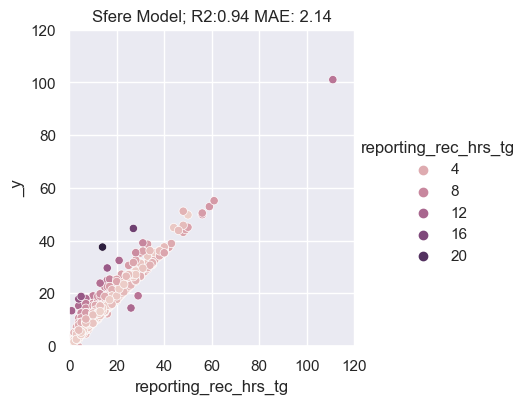

coef:  [11.72296678  0.20096705]


In [139]:
try_features(['reporting_current_hrs_ft', 'age_ft'])

features ['reporting_current_hrs_ft', 'total_impairment']


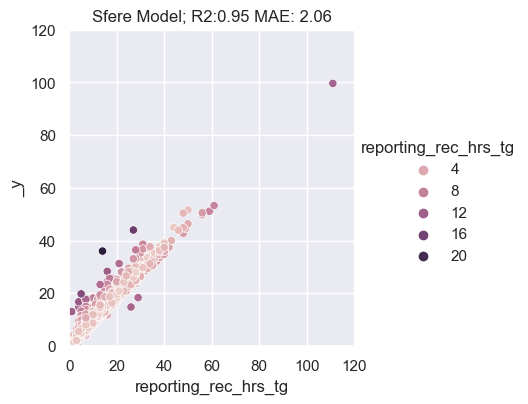

coef:  [11.28479822  0.89006178]


In [140]:
try_features(['reporting_current_hrs_ft', 'total_impairment'])

features ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment']


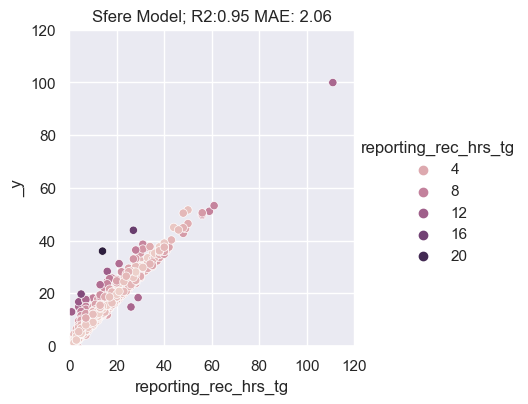

coef:  [11.28307265 -0.06746103  0.90426276]


In [141]:
try_features(['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment'])

features ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment', 'total_dme', 'total_cog']


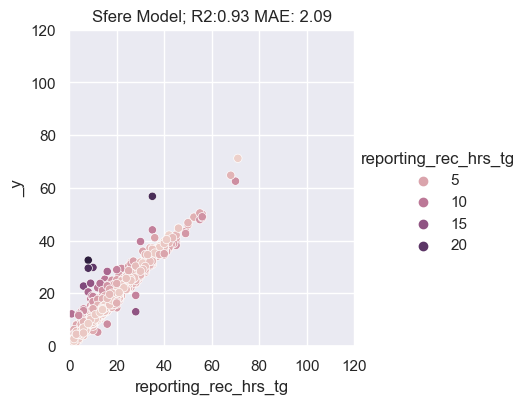

coef:  [11.31873346 -0.11259214  0.81464053 -0.31265656 -0.31265656]


In [150]:
try_features(['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment', 'total_dme', 'total_cog'])

features ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment', 'total_dme', 'total_cog']


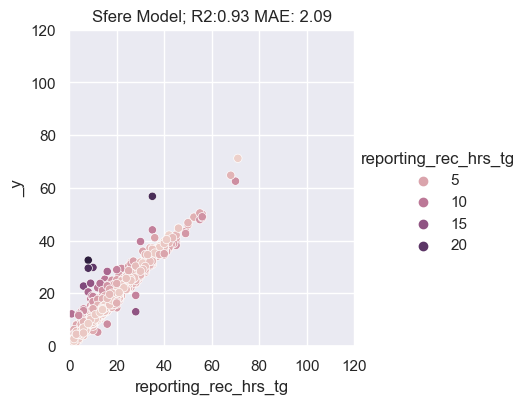

coef:  [11.31873346 -0.11259214  0.81464053 -0.31265656 -0.31265656]


In [152]:
try_features(['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment', 'total_dme', 'total_cog'])

features ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment']


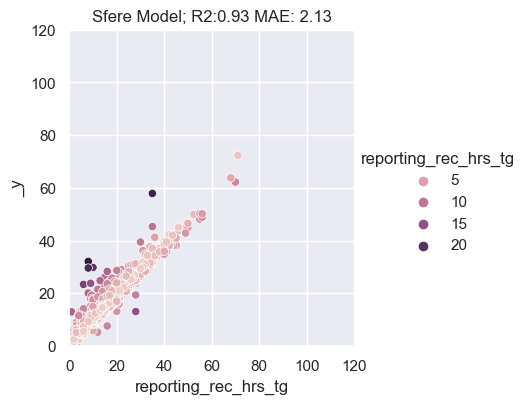

coef:  [11.37446056 -0.06043819  0.92669894]


In [158]:
try_features(['reporting_current_hrs_ft', 'mean_supports_ft',  'total_impairment'])

features ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment']


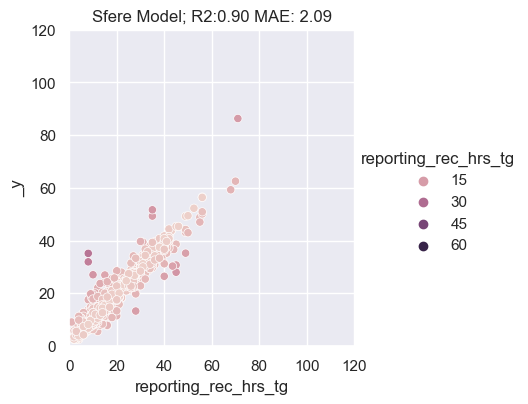

In [161]:
features = ['reporting_current_hrs_ft', 'mean_supports_ft', 'total_impairment']
print('features', features)
x_train = training_df[features]
x_test = test_df[features]
pipe = HistGradientBoostingRegressor(max_iter=1000)

pipe.fit(x_train, y_train)

preds = pipe.predict(x_test)

# preds vs rec
ax = sns.relplot(x=y_test, y=preds, height=4, hue=np.abs(y_test - preds))
ax.set(ylim=(0, 120))
ax.set(xlim=(0, 120))
ax.set(title=f'Sfere Model; R2:{pipe.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}');
plt.show()


# print('coef: ', pipe['ridge'].coef_)

In [71]:
null_counts = df.isnull().sum(axis = 0)
for col, missing in null_counts.iteritems():
    print(col, missing)

sfere_id 0
patient_id 0
sfere_type_ft 0
payer_id_ft 0
group_id_ft 0
age_ft 0
transfer_bed_to_chair_ft 0
mobility_ft 0
dressing_ft 0
bathing_ft 0
eating_ft 0
grooming_ft 196
toileting_ft 0
turn_change_position_ft 7200
has_incontinence_ft 0
incontinence_type_ft 1838
incontinence_frequency_ft 1731
bathing_support_days_natural_ft 6461
dressing_support_days_natural_ft 6284
eating_support_days_natural_ft 6532
grooming_support_days_natural_ft 6516
toileting_support_days_natural_ft 6318
mobility_support_days_natural_ft 6402
transfer_bed_to_chair_support_days_natural_ft 6347
turn_change_position_support_days_natural_ft 7200
bathing_transfers_support_days_natural_ft 7200
dressing_lower_support_days_natural_ft 7200
hair_support_days_natural_ft 7200
mobility_outside_support_days_natural_ft 7200
calling_friends_and_family_ft 0
articulating_needs_ft 2452
meal_prep_ft 0
shopping_ft 0
medication_management_ft 0
finances_ft 0
housework_ft 0
transportation_ft 0
daily_routine_decisions_ft 2595
comprehens

### Test training on file

In [11]:
df = fl_features
# df.columns = final_columns
df.head()

,sfere_id,patient_id,sfere_type_ft,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,bathing_support_days_natural_ft,dressing_support_days_natural_ft,eating_support_days_natural_ft,grooming_support_days_natural_ft,toileting_support_days_natural_ft,mobility_support_days_natural_ft,transfer_bed_to_chair_support_days_natural_ft,turn_change_position_support_days_natural_ft,bathing_transfers_support_days_natural_ft,dressing_lower_support_days_natural_ft,hair_support_days_natural_ft,mobility_outside_support_days_natural_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,calling_friends_and_family_support_days_natural_ft,finances_support_days_natural_ft,laundry_support_days_natural_ft,housework_support_days_natural_ft,meal_prep_support_days_natural_ft,medication_management_support_days_natural_ft,shopping_support_days_natural_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alz_or_dem_ft,has_acquired_cognitive_deficit_ft,has_developmental_delay_ft,has_idd_ft,has_no_cog_deficit_ft,has_traumatic_brain_injury_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,mean_supports_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,8590,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,14.0,14.0
1,55517,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,14.0,14.0
2,6376,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,20.0,20.0
3,6380,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,20.0
4,76130,2115,2,4,2,69.0,3,0,3,3,3,3.0,3,None,1,2.0,2.0,2.0,2.0,7.0,7.0,7.0,NaN,NaN,None,None,None,None,None,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,None,3.0,None,None,None,None,None,NaN,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,5.75,20.0,20.0


1043 test samples, for 796 unique patients
6921 training samples, for 5225 unique patients


In [14]:
features = final_columns[1:]
target = final_columns[0]
categorical_feature_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]

In [17]:
x_train = training_df[features]
y_train = training_df[target]
x_test = test_df[features]
y_test = test_df[target]

est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

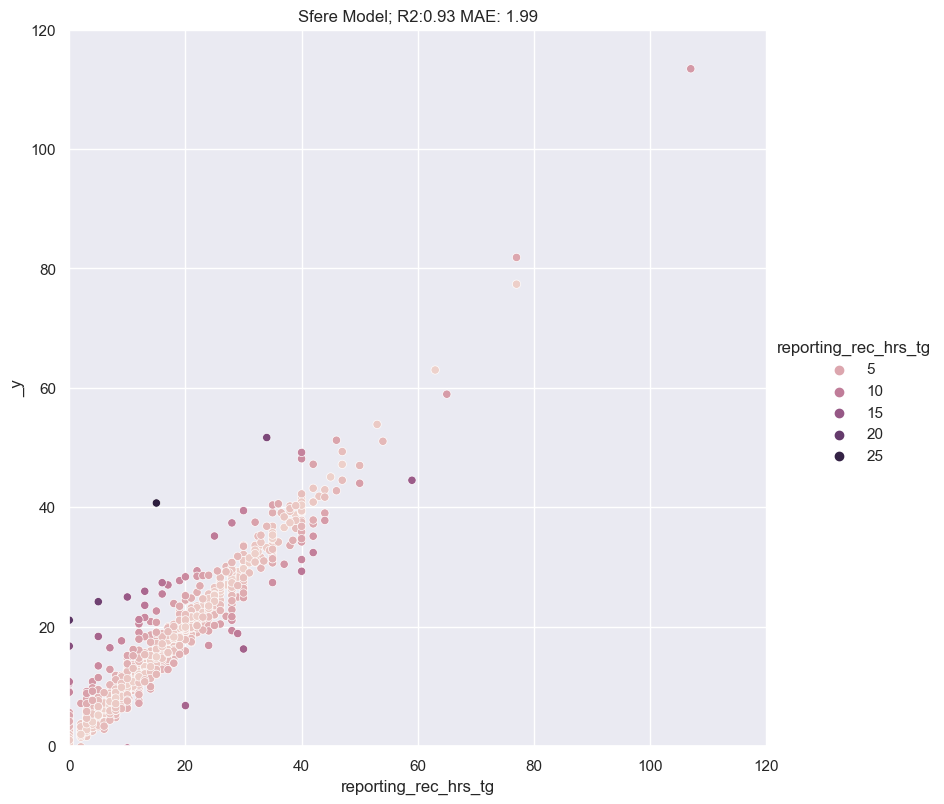

In [18]:
preds = est.predict(x_test)

# preds vs rec
ax = sns.relplot(x=y_test, y=preds, height=8, hue=np.abs(y_test - preds))
ax.set(ylim=(0, 120))
ax.set(xlim=(0, 120))
ax.set(title=f'Sfere Model; R2:{est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}');
plt.show()


In [63]:
print(f'Feature importances on training')
r = permutation_importance(est, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances on training
reporting_current_hrs_ft 1.507  +/- 0.020
age_ft   0.017  +/- 0.000
receiving_enteral_feedings_ft 0.012  +/- 0.001
toileting_ft 0.011  +/- 0.000
bathing_ft 0.009  +/- 0.000
eating_ft 0.008  +/- 0.000
housework_ft 0.008  +/- 0.000
dressing_ft 0.007  +/- 0.000
grooming_ft 0.006  +/- 0.000
meal_prep_ft 0.005  +/- 0.000
mobility_ft 0.004  +/- 0.000
medication_management_ft 0.004  +/- 0.000
transfer_bed_to_chair_ft 0.004  +/- 0.000
shopping_ft 0.004  +/- 0.000
mean_supports_ft 0.004  +/- 0.000
incontinence_frequency_ft 0.004  +/- 0.000
member_opinion_ft 0.003  +/- 0.000
receive_wound_care_ft 0.003  +/- 0.000
incontinence_type_ft 0.002  +/- 0.000
calling_friends_and_family_ft 0.002  +/- 0.000
transportation_ft 0.002  +/- 0.000
payer_id_ft 0.002  +/- 0.000
finances_ft 0.002  +/- 0.000
using_mobility_device_ft 0.001  +/- 0.000
using_specialized_bed_ft 0.001  +/- 0.000
has_dme_ft 0.001  +/- 0.000
articulating_needs_ft 0.001  +/- 0.000
daily_routine_decisions_ft 0

In [64]:
print(f'Feature importances on test')
r = permutation_importance(est, x_test, y_test,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances on test
reporting_current_hrs_ft 1.472  +/- 0.052
toileting_ft 0.009  +/- 0.002
bathing_ft 0.007  +/- 0.001
housework_ft 0.004  +/- 0.001
mean_supports_ft 0.003  +/- 0.001
dressing_ft 0.003  +/- 0.001
meal_prep_ft 0.002  +/- 0.001
shopping_ft 0.002  +/- 0.001
driving_ft 0.001  +/- 0.000


In [65]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

Computing partial dependence plots...
done in 21.350s


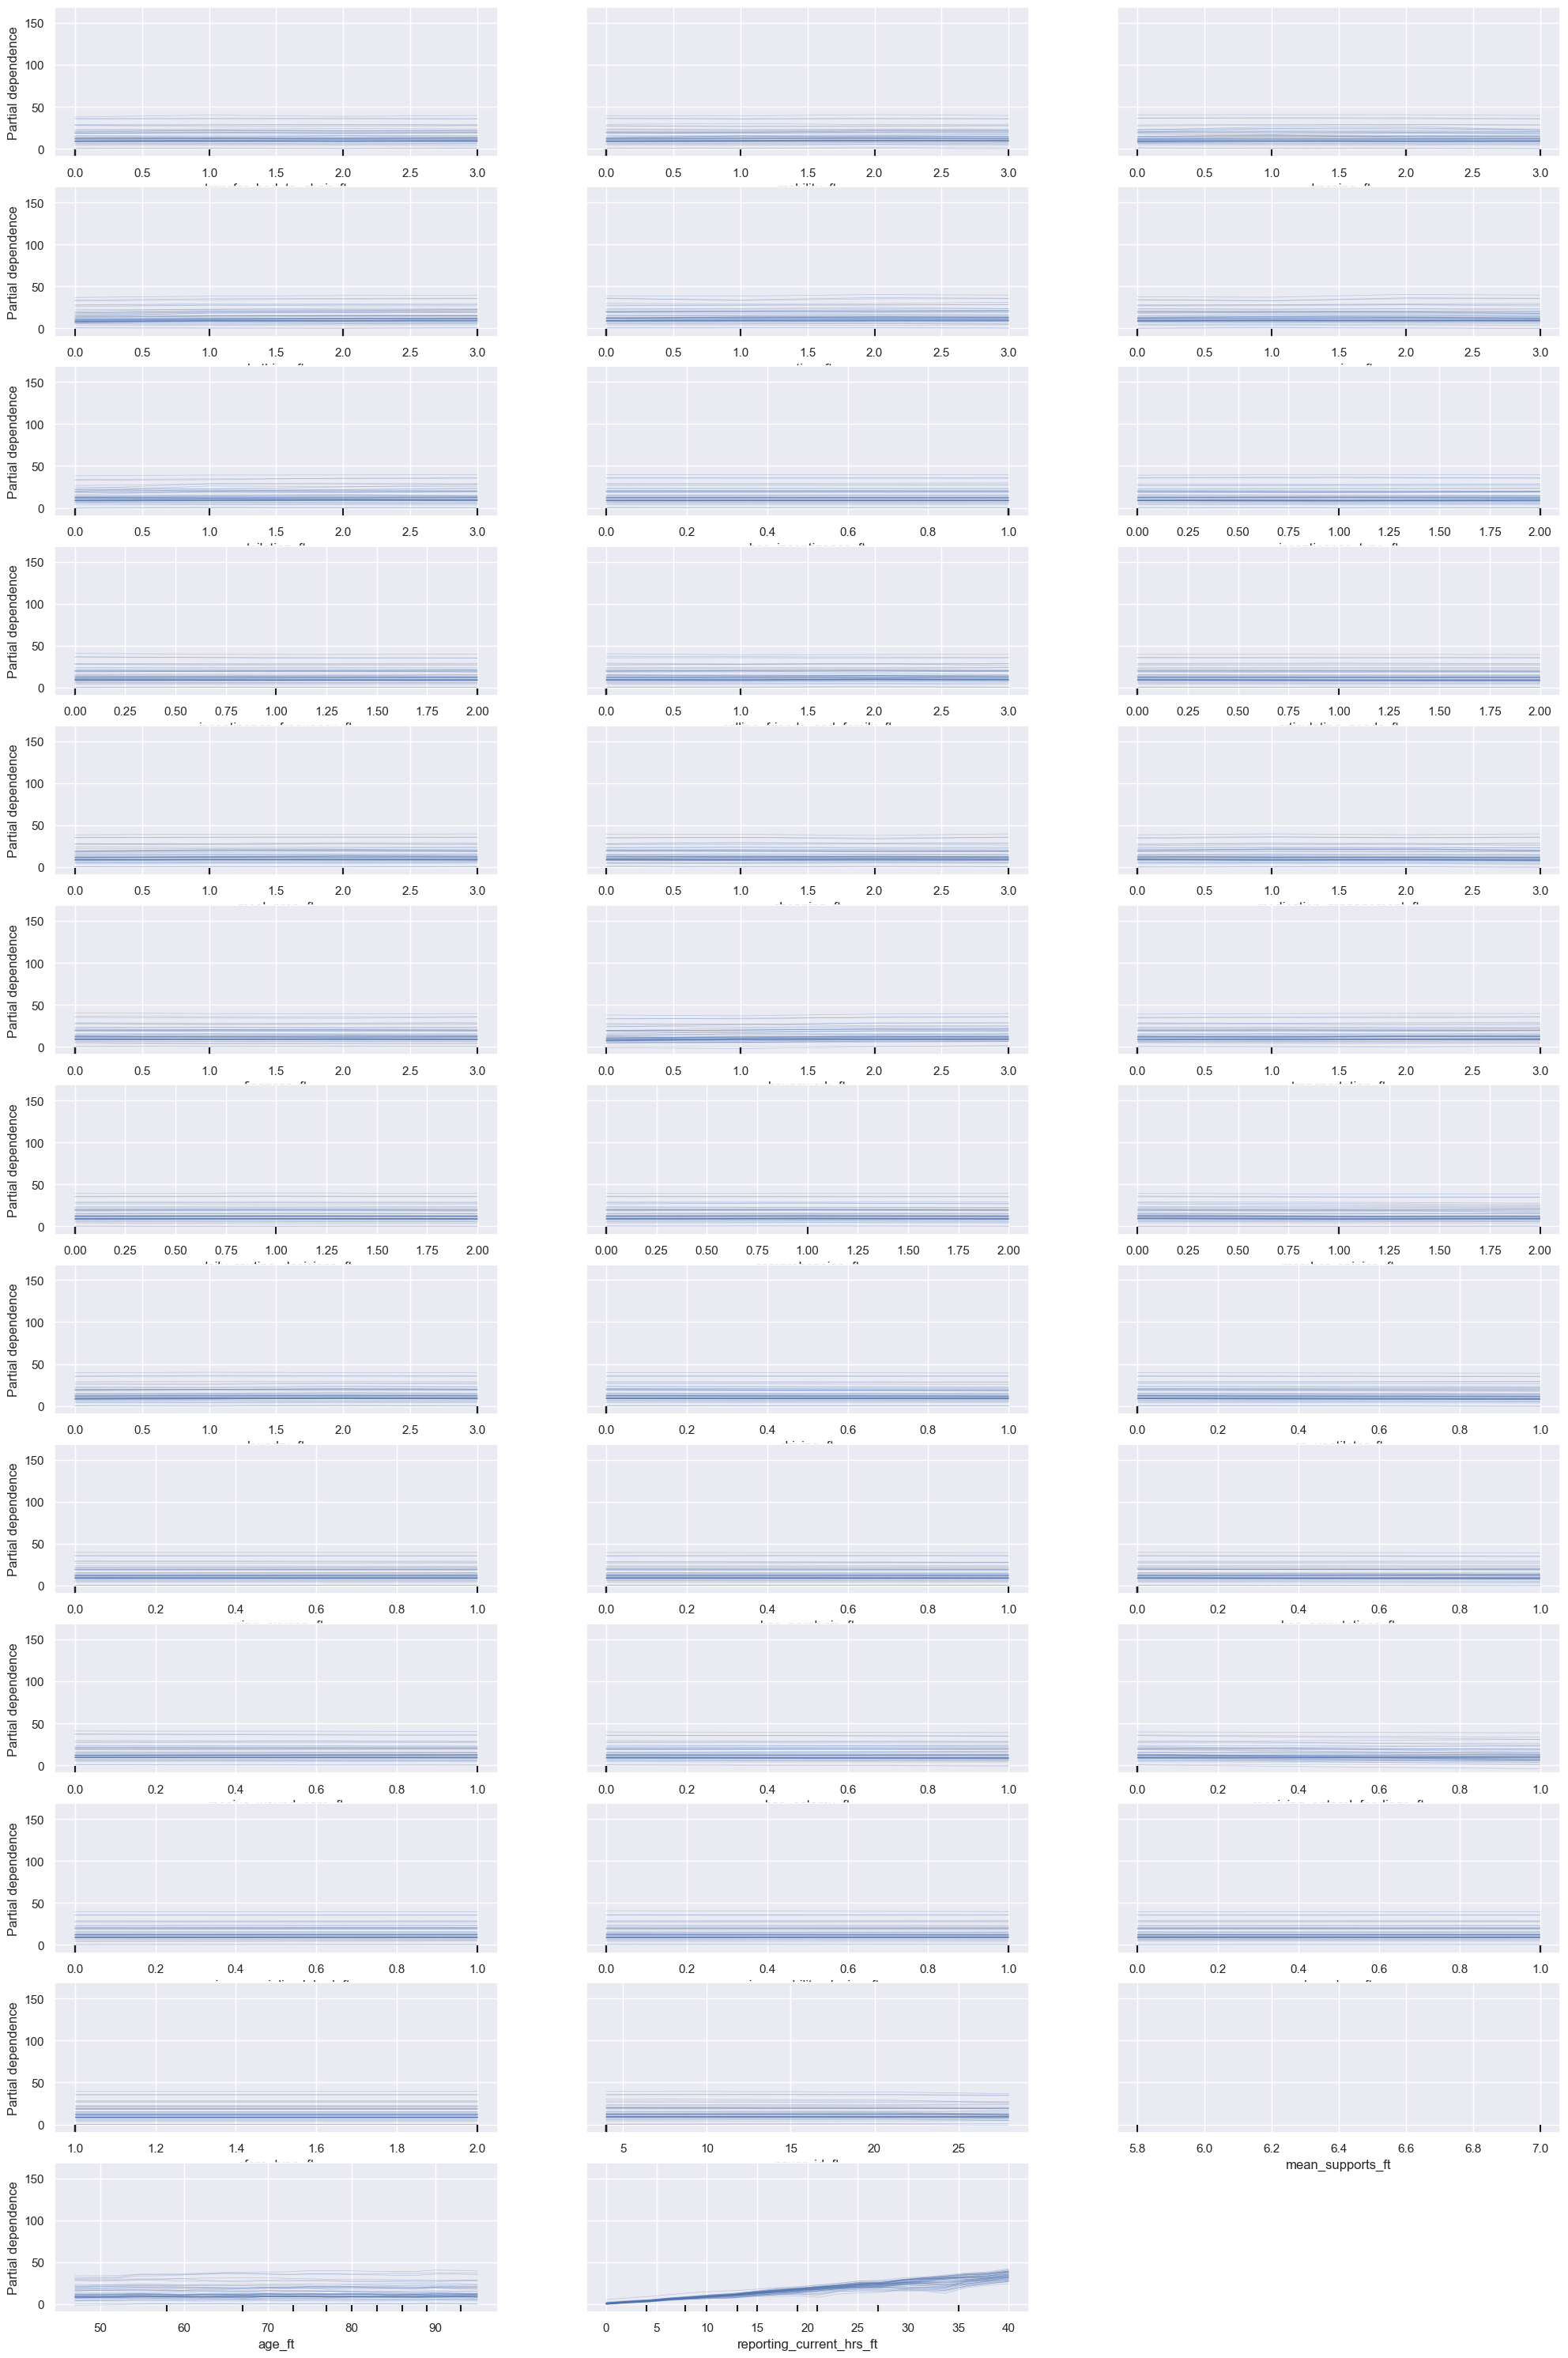

In [60]:
from time import time
from sklearn.inspection import PartialDependenceDisplay


print("Computing partial dependence plots...")
tic = time()

n_features = 38
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features=[i for i in range(n_features)],
    feature_names=[x_train.columns[i] for i in range(n_features)], 
    kind='individual',
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
display.figure_.set_figwidth(20)
display.figure_.set_figheight(30)
display.figure_.tight_layout()